## Introduction

## Choice of Grading

    Our project should be graded more heavily on data analysis.This decision was made as the dataset was mostly clean and well formatted except for missing values.

## Data Cleaning and Processing

In order to run the data cleaning and the analysis done in this notebook,make sure the libraries **reverse_geocoder** and **matplotlib_venn** are installed in the environment.

In [ ]:
#import necessary libraries for the project
import pandas as pd
import numpy as np
import re
import reverse_geocoder as rg #This library translates longitudes and latitudes information into area/region/city/country
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from datetime import datetime
from calendar import day_name, month_name
import plotly.graph_objects as go

Initiate the loading of the dataset acquired from the official Montgomery County government website.

In [ ]:
#load dataset into dataframe
df = pd.read_csv(r'Traffic_Violations.csv')

This cell identifies and sorts missing values in the DataFrame. Using `df.isnull().sum()`, we determine the count of null values in each column, focusing on those with missing data, to inform our data cleaning strategy.

In [ ]:
#We have few float64 and bool. But, most of our columns contain np object type.
#Now, we need to check for missing values
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending = True)

Location                       1
Description                    8
Driver State                   8
Make                          25
State                         50
Model                         86
Driver City                  168
DL State                     831
Article                     1406
Year                        5989
Color                      15952
Search Conducted          460439
Search Reason For Stop    460664
Search Outcome            479510
Search Reason             980124
Search Disposition        980124
Search Type               980131
Search Arrest Reason      997148
dtype: int64

Now we will employ geographical coordinates to retrieve the location name for entries with missing **Location** data. After extracting the location name, it is then assigned to the respective missing entries in the **Location** column of our DataFrame. Subsequently, the cell re-evaluates the DataFrame to confirm the rectification of missing 'Location' data.

In [ ]:
#Let us examin Geolocation coordinates for this missing location
geo_info = df.loc[df.Location.isnull(),'Geolocation'].values[0]
#We have Longitude and Latitude information available for this missing observation.
#Let's extract coordinates of the location
values = geo_info.replace("(", "").replace(")", "").split(',')

# Convert the strings to floats
geo_coordinates = [float(value) for value in values]


Additionally, to address the issue of dummy geolocation data, represented as '(0.0, 0.0)', we will be replacing them with NaN. This step ensures the accuracy of our geographical data.

In [ ]:
#use coordinates to extract location name
location_data = rg.search((geo_coordinates))

location_name = location_data[0]['name']


Loading formatted geocoded file...


In [ ]:
#copy location name to the missing cell
df.loc[df.Location.isnull(), 'Location'] = location_name

In [ ]:
#We also need to make sure that there is no dummy data for Geolocation like '(0.0, 0.0)'
df[df.Geolocation == '(0.0, 0.0)'].Geolocation
df.loc[df.Geolocation == '(0.0, 0.0)', ['Longitude', 'Latitude']].head()
#We see that Longitude and Latitude information is also zero.
#These are dummy entries. We can replace them with NaN.
df.loc[df.Geolocation == '(0.0, 0.0)', 'Longitude'] = np.nan
df.loc[df.Geolocation == '(0.0, 0.0)', 'Latitude'] = np.nan
df.loc[df.Geolocation == '(0.0, 0.0)', 'Geolocation'] = np.nan


Now we will review the status of missing information across **Description** column.There is no informaiton available in any cell, which can guide us about description of the violation.But using the information from the **Charge** column, we can check articles one by one from the website.For example,for 1st violation, we refer to https://www.law.cornell.edu/cfr/text/49/391.11 and we can find that it was use of vehicle for commercial purposes, without commercial license, we can upate the inforamtion with our desription.This step could be continued for all the missing values

In [ ]:
# Replace missing values in Description column
df.loc[df[df.Description.isnull()].index[0],'Description'] = 'Commercial use of unauthorized vehicle' #https://www.law.cornell.edu/cfr/text/49/391.11
df.loc[df[df.Description.isnull()].index[0],'Description'] = 'Driving under alcohol influence while transporting a minor' #https://mgaleg.maryland.gov/mgawebsite/Laws/StatuteText?article=gtr&section=21-902&enactments=false#:~:text=%C2%A721%E2%80%93902.,influence%20of%20alcohol%20per%20se.
df.loc[df[df.Description.isnull()].index[0],'Description'] = 'Driving with a minor under 16 years of age without child seat or seat belt'     #https://mgaleg.maryland.gov/mgawebsite/Laws/StatuteText?article=gtr&section=22-412.3&enactments=false#:~:text=%C2%A722%E2%80%93412.3.,words%20have%20the%20meanings%20indicated.&text=2.,the%20Code%20of%20Federal%20Regulations.
df.loc[df[df.Description.isnull()].index[0],'Description'] = 'Did not yield pedistrian or rightful vehicle' #https://law.justia.com/codes/maryland/2018/transportation/title-21/subtitle-2/section-21-209/#:~:text=Vehicular%20traffic%20approaching%20a%20nonfunctioning,before%20entering%20any%20crosswalk%3B%20or
df.loc[df[df.Description.isnull()].index[0],'Description'] = 'Did not yield pedistrian or rightful vehicle' #https://law.justia.com/codes/maryland/2018/transportation/title-21/subtitle-2/section-21-209/#:~:text=Vehicular%20traffic%20approaching%20a%20nonfunctioning,before%20entering%20any%20crosswalk%3B%20or
df.loc[df[df.Description.isnull()].index[0],'Description'] = 'Overspeeding on Highway' #https://mgaleg.maryland.gov/mgawebsite/Laws/StatuteText?article=gtr&section=21-801&enactments=false#:~:text=%C2%A721%E2%80%93801.,and%20prudent%20under%20the%20conditions.
df.loc[df[df.Description.isnull()].index[0],'Description'] = 'Use of mobile phone while driving' #https://law.justia.com/codes/maryland/2013/article-gtr/section-21-1124#:~:text=%C2%A7%2021%2D1124%20%2D%201.&text=(b)%20In%20general.,travel%20portion%20of%20the%20roadway.&text=(2)%20A%20text%20messaging%20device,9%2D1%2D1%20system.
df.loc[df[df.Description.isnull()].index[0],'Description'] = 'Drivig without a license' #https://www.marylanddefenseattorney.net/driving-without-a-license-in-maryland-penalties-fines/#:~:text=In%20Maryland%2C%20driving%20without%20a,Maryland%20and%20not%20a%20felony.

Now,for the 2 columns, **State** and **Driver State**,there should be common inferences.So, we start from the column, which has large portion of missing information which is the **State** column

In [ ]:
# Filter State values that are null
missing_state = df.loc[df.State.isnull()]

Wecan  assume that Vehicle's state is same as driver's state. Although, there may be few cases, where it might not be true, for example, in case of using a rental vehicle. But, it's a fraction of a fraction, so we can ignore this.


In [ ]:
#Assign the vehcile state as sriver state
df.loc[df.State.isnull(), 'State'] = df.loc[df.State.isnull(), 'Driver State']

In couple of cases, Driver State is missing, but Driving License state is available. We assume that the driving license was issued from driver's state. Let's use this information to impute missing data for the entries where Driver State is missing

In [ ]:
#Impute the Driver State column
df.loc[df['Driver State'].isnull(), 'Driver State'] = df.loc[df['Driver State'].isnull(), 'DL State']

In [ ]:
#We still have few entries missing. Let's use the same logic and use 'State' value for 'Driver State'
df.loc[df['Driver State'].isnull(), 'Driver State'] = df.loc[df['Driver State'].isnull(), 'State']

Now,the columns **Make**,**Color** and **Model** are not relevant to our analysis.So we can ignore these columns.  
There is no source of information to inform about **Driver City** and as we have 'Driver State' information, which is more relevent to our analysis we can ignore this.  
We shall also ignore **Year** of the vehicle. It is a very important feature to understand old vs. new vehicles and their drivers. But, this is not part of our analysis.We will modify the column to represent the year the violation was reported


In [ ]:
#Let us delete these columns to clean up the data
del(df['Make'])
del(df['Model'])
del(df['Driver City'])
del(df['Color'])

df['Date Of Stop'] = pd.to_datetime(df['Date Of Stop'])

# Extract the year from the 'Date Of Stop' column and create a new column 'Year'
df['Year'] = df['Date Of Stop'].dt.year

In [ ]:
df['Date Of Stop'] = pd.to_datetime(df['Date Of Stop'])

# Extract the year from the 'Date Of Stop' column and create a new column 'Year'
df['Year'] = df['Date Of Stop'].dt.year

Now, let's examine missing driving license states, and driver state column in those observations.We assume that Driver got license from his home state. So, we can use this information to fill in missing data for DL State

In [ ]:
#We assume that Vehicle State is same state as Driver's state and Driving License State
df.loc[df['DL State'].isnull(), 'DL State'] = df.loc[df['DL State'].isnull(), 'Driver State']

Now let us process **Violation Type** column.Let us see what kind of violations were registered without citing any article

In [ ]:
df.loc[df.Article.isnull()]['Violation Type'].unique()

array(['ESERO', 'SERO'], dtype=object)

We see that two types of violations are usually not cited with any article.We further investigate if it is always the case.


In [ ]:
df.loc[(df['Violation Type'] == 'ESERO') | (df['Violation Type'] == 'SERO')].Article.unique()

array([nan], dtype=object)

We conclude that for in this case, citation Article is never mentioned.To get better understanding of this phenomenon, we did some research.After doing some research on State of Maryland website, we found that these are 'Safety Equipment Repair Orders'. There is no Article regarding this, these are advisory orders for owners to fix the vehicle issues ASAP.  
Refer to https://mva.maryland.gov/about-mva/Pages/info/58000ASE/58000-04T.aspx for more details.  
It is state as "A Maryland State Police Trooper or any other Maryland law enforcement officer may issue a Safety Equipment Repair Order (SERO) to the operator of a vehicle that is observed to have defective or non-functioning equipment in accordance with Maryland laws and regulations"  
Furthermore "The SERO requires the vehicle owner to have the problems cited on the SERO repaired within 10 days, and a certification of the repair to be submitted to the Maryland State Police (MSP) Automotive Safety Enforcement Division (ASED) within 30 days."  
Now, Let's replace this missing information with 'State Repair Order'.

In [ ]:
#Impute the column with the required value
df.loc[(df['Violation Type'] == 'ESERO') | (df['Violation Type'] == 'SERO'), 'Article'] = 'State Fitness Requirement'

Now,we will addresse the missing information in the **Search Conducted** column. Based on our research into legal procedures, we understand that searches should be either pre-planned with warrants or properly documented. Therefore, any missing entries in this column likely indicate that no search was conducted, rather than data entry errors, since police compliance is typically high due to the potential for severe consequences and public access to these records. Consequently, we assume that missing data in **Search Conducted** signifies an absence of search, and we replace these with 'No'.

In [ ]:
#We can replace the missing information with 'No'
df.loc[df['Search Conducted'].isnull(),'Search Conducted'] = 'No'

If there was no search conducted, there is no way there will be a **Search Disposition**,**Search Outcome** or **Search Reason**.So,in such cases,null values can be replaced with Nothing.

In [ ]:
#Now, let's replace NaN with 'Nothing'
df.loc[df['Search Conducted'] == 'No', 'Search Disposition'] = 'Nothing'
#We also replace 'nothing' with 'Nothing'
df.loc[df['Search Conducted'] == 'nothing', 'Search Disposition'] = 'Nothing'
#We also replace 'nan' with 'Nothing'
df.loc[df['Search Conducted'] == np.nan, 'Search Disposition'] = 'Nothing'

In [ ]:
#Let's run same exercise for 'Search Outcome'
df.loc[df['Search Conducted'] == 'No', 'Search Outcome'] = 'Nothing'
#We can also replace 'nan' with 'Nothing'
df.loc[df['Search Conducted'] == np.nan, 'Search Outcome'] = 'Nothing'

In [ ]:
#We do same for 'Search Reason'
df.loc[df['Search Conducted'] == 'No', 'Search Reason'] = 'Nothing'

In [ ]:
#We do same for 'Search Reason for Stop'
df.loc[df['Search Conducted'] == 'No', 'Search Reason For Stop'] = 'Nothing'

In [ ]:
#We do same for 'Search Type'
df.loc[df['Search Conducted'] == 'No', 'Search Type'] = 'Nothing'

In [ ]:
#We do same for 'Search Arrest Reason'
df.loc[df['Search Conducted'] == 'No', 'Search Arrest Reason'] = 'Nothing'

In [ ]:
#For Search type missing, let's confirm that Search was conducted.
df[df['Search Type'].isnull()]['Search Conducted']

601496    Yes
601499    Yes
601503    Yes
601505    Yes
601510    Yes
601512    Yes
601517    Yes
Name: Search Conducted, dtype: object

For **Search Type** and **Search Arrest Reason** column, fill the null values with 'No Information Registered'

In [ ]:
df.loc[df['Search Type'].isnull(),'Search Type'] = 'No Information Registered'
df.loc[df['Search Type'] == 'Nothing' ,'Search Type'] = 'No Information Registered'
df.loc[df['Search Type'] == 'nan' ,'Search Type'] = 'No Information Registered'

In [ ]:
df.loc[df['Search Arrest Reason'].isnull(),'Search Arrest Reason'] = 'No Information Registered'

In [ ]:
#Let us check all columns for missing values now.
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending = True)

Latitude       84378
Longitude      84378
Geolocation    84378
dtype: int64

## Data Analysis

### 1. Analysis on Drivers' Negligence Causing Personal Injuries or Property Damages

We tried to understand the most frequent charges for traffic violations that **resulted in accidents**. Based on our exploration, we discovered that there are 10,645 charges for speeding on highways (21-801(b)), which is the highest occuring charge in the data set.

In [ ]:
# Count of unique values under charges
df[df['Accident'] == 'Yes']['Charge'].value_counts().head(10)

21-801(b)      10645
21-901.1(b)     3938
21-402(a)       2893
21-901.1(a)     1793
21-201(a1)      1655
21-309(b)       1589
21-202(h1)      1364
21-301(a)       1184
21-902(a1i)     1098
21-902(b1i)     1096
Name: Charge, dtype: int64

When we look at the most frequent charges for traffic violations that resulted in **property damages** and **personal injuries**, we can see that the most frequent charges are very similar to those resulting in accidents.

In [ ]:
df[df['Property Damage'] == 'Yes']['Charge'].value_counts().head(10)

21-801(b)      6620
21-901.1(b)    2563
21-402(a)      1342
21-901.1(a)    1195
21-309(b)      1103
20-105.1       1087
16-112(c)      1075
21-902(b1)      973
21-902(a1)      965
20-103(b)       942
Name: Charge, dtype: int64

### Data Visualization - Stacked Bar Chart
This script analyzes traffic violation data, focusing on specific charges and their outcomes in terms of personal injury, property damage, or other accidents.

#### Speeding on Highways (Charge Code: 21-801(b))
- speeding_injury: Counts violations under charge '21-801(b)' resulting in **personal injury**.
- speeding_damage: Counts violations under charge '21-801(b)' resulting in **property damage**.
- speeding_nothing: Counts violations under charge '21-801(b)' with **other accidents that is neither personal injury nor property damage**.

In [ ]:
# 21-801(b): Speeding on highways
# Count violations under the charge '21-801(b)' which also resulted in personal injury
speeding_injury = len(df[(df['Charge'] == '21-801(b)') & (df['Personal Injury'] == 'Yes')])
# Count violations under the charge '21-801(b)' which also resulted in property damage
speeding_damage = len(df[(df['Charge'] == '21-801(b)') & (df['Property Damage'] == 'Yes')])
# Count violations under the charge '21-801(b)'but resulted in neither personal injury nor property damage
speeding_nothing = len(df[(df['Charge'] == '21-801(b)') & (df['Accident'] == 'Yes') \
                          & (df['Property Damage'] == 'No') & (df['Personal Injury'] == 'No')])

#### Repeat Analysis for Other Top Charges
The same process is repeated for other top charges such as:
- Negligent Driving (21-901.1(b))
- Failure to Yield (21-402(a))
- Reckless Driving (21-901.1(a))
- Disobeying Traffic Control (21-201(a1))
- Dangerous Lane Switching (21-309(b))<br>

For each charge, counts are calculated for incidents involving **personal injury**, **property damage**, or **other consequences**.

In [ ]:
# 21-901.1(b): Negligent driving
neglect_injury = len(df[(df['Charge'] == '21-901.1(b)') & (df['Personal Injury'] == 'Yes')])
neglect_damage = len(df[(df['Charge'] == '21-901.1(b)') & (df['Property Damage'] == 'Yes')])
neglect_nothing = len(df[(df['Charge'] == '21-901.1(b)') & (df['Accident'] == 'Yes') \
                         & (df['Property Damage'] == 'No') & (df['Personal Injury'] == 'No')])
# 21-402(a): Fail to yield
no_yield_injury = len(df[(df['Charge'] == '21-402(a)') & (df['Personal Injury'] == 'Yes')])
no_yield_damage = len(df[(df['Charge'] == '21-402(a)') & (df['Property Damage'] == 'Yes')])
no_yield_nothing = len(df[(df['Charge'] == '21-402(a)') & (df['Accident'] == 'Yes') \
                          & (df['Property Damage'] == 'No') & (df['Personal Injury'] == 'No')])
# 21-901.1(a): Reckless driving
reckless_injury = len(df[(df['Charge'] == '21-901.1(a)') & (df['Personal Injury'] == 'Yes')])
reckless_damage = len(df[(df['Charge'] == '21-901.1(a)') & (df['Property Damage'] == 'Yes')])
reckless_nothing = len(df[(df['Charge'] == '21-901.1(a)') & (df['Accident'] == 'Yes') \
                          & (df['Property Damage'] == 'No') & (df['Personal Injury'] == 'No')])
# 21-201(a1): Didn't Obey Traffic Control
no_obey_control_injury = len(df[(df['Charge'] == '21-201(a1)') & (df['Personal Injury'] == 'Yes')])
no_obey_control_damage = len(df[(df['Charge'] == '21-201(a1)') & (df['Property Damage'] == 'Yes')])
no_obey_control_nothing = len(df[(df['Charge'] == '21-201(a1)') & (df['Accident'] == 'Yes') \
                                 & (df['Property Damage'] == 'No') & (df['Personal Injury'] == 'No')])
# 21-309(b): Dangerous Lane Switching
lane_switching_injury = len(df[(df['Charge'] == '21-309(b)') & (df['Personal Injury'] == 'Yes')])
lane_switching_damage = len(df[(df['Charge'] == '21-309(b)') & (df['Property Damage'] == 'Yes')])
lane_switching_nothing = len(df[(df['Charge'] == '21-309(b)') & (df['Accident'] == 'Yes') \
                                & (df['Property Damage'] == 'No') & (df['Personal Injury'] == 'No')])

#### Aggregate Counts for Top Charges
Total counts for **each consequence category** across the top 6 charges are calculated.

In [ ]:
# Count the total of the above Top 6 Charges and sort them according to consequences
top_charge_injury = speeding_injury+neglect_injury+no_yield_injury+reckless_injury+no_obey_control_injury+lane_switching_injury
top_charge_damage = speeding_damage+neglect_damage+no_yield_damage+reckless_damage+no_obey_control_damage+lane_switching_damage
top_charge_nothing = speeding_nothing+neglect_nothing+no_yield_nothing+reckless_nothing+no_obey_control_nothing+lane_switching_nothing

#### Analysis of Other Charges
For charges **not in the top 6**, their counts are calculated by subtracting the totals of top charges from the overall category totals.

In [ ]:
# Other Charges
# Calculate the count of charges other than the top 6 by subtracting the top_charge totals from their category
other_injury = len(df[(df['Personal Injury'] == 'Yes')]) - top_charge_injury
other_damage = len(df[(df['Property Damage'] == 'Yes')]) - top_charge_damage
other_nothing = len(df[(df['Accident'] == 'Yes') & (df['Property Damage'] == 'No')
                       & (df['Personal Injury'] == 'No')]) - top_charge_nothing

#### Create the Bar Chart
The provided Python code snippet is designed to visualize traffic violation data through a stacked bar chart using Matplotlib. This chart illustrates ***the distribution of various traffic charges and their associated consequences**, which include personal injuries, property damages, and other types of accidents. This visualization aids in understanding the **relative frequencies of different consequences for various traffic violations**, providing insightful data representation for analysis or reporting purposes.

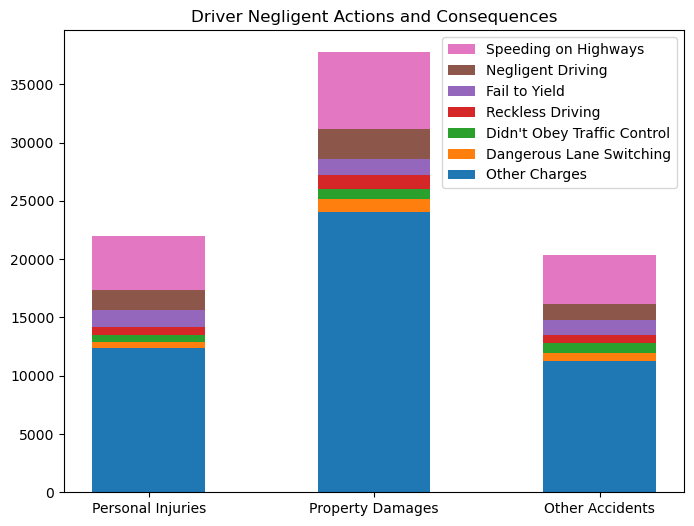

In [ ]:
# Consequences of violation (X-axis labels)
consequences = (
    "Personal Injuries",
    "Property Damages",
    "Other Accidents",
)
# Charges given to each violation
# Including count of injury, damage, and nothing caused violation under each charge
charges = {
    "Other Charges": np.array([other_injury, other_damage, other_nothing]),
    "Dangerous Lane Switching": np.array([lane_switching_injury, lane_switching_damage, lane_switching_nothing]),
    "Didn't Obey Traffic Control": np.array([no_obey_control_injury, no_obey_control_damage, no_obey_control_nothing]),
    "Reckless Driving": np.array([reckless_injury, reckless_damage, reckless_nothing]),
    "Fail to Yield": np.array([no_yield_injury, no_yield_damage, no_yield_nothing]),
    "Negligent Driving": np.array([neglect_injury, neglect_damage, neglect_nothing]),
    "Speeding on Highways": np.array([speeding_injury, speeding_damage, speeding_nothing]),
}
width = 0.5 # Set bar width

fig, ax = plt.subplots(figsize = (8,6)) # Set figure size to fit legend on top right
bottom = np.zeros(3) # Set the bottom of each bar to 0 to make sure they stick to the bottom

# Stack all the charges into stacked bar charts and set legend titles with charge name
for charge_name, charge_count in charges.items():
    p = ax.bar(consequences, charge_count, width, label = charge_name, bottom = bottom)
    bottom += charge_count # Renew the bottom to stack one charge on top of another

ax.set_title("Driver Negligent Actions and Consequences") # Set graph title
handles, labels = ax.get_legend_handles_labels() # Get the handles and labels in the legend
ax.legend(handles[::-1], labels[::-1], loc="upper right") # Reverse the order of legend to match the bar pattern

plt.show()

2.

## 2.

In [ ]:
# Creating a copy of the original DataFrame to preserve the original data
df_traffic_violations=df.copy()

In [ ]:
# This provides a distinct list of vehicle types present in the dataset
df_traffic_violations['VehicleType'].unique()

array(['02 - Automobile', '01 - Motorcycle', '05 - Light Duty Truck',
       '12 - School Bus', '03 - Station Wagon', '28 - Other',
       '06 - Heavy Duty Truck', '29 - Unknown', '19 - Moped',
       '10 - Transit Bus', '07 - Truck/Road Tractor',
       '25 - Utility Trailer', '20 - Commercial Rig',
       '08 - Recreational Vehicle', '04 - Limousine',
       '11 - Cross Country Bus', '27 - Farm Equipment',
       '18 - Police(Non-Emerg)', '14 - Ambulance(Non-Emerg)',
       '24 - Camper', '13 - Ambulance(Emerg)', '23 - Travel/Home Trailer',
       '21 - Tandem Trailer', '15 - Fire(Emerg)', '26 - Boat Trailer',
       '09 - Farm Vehicle', '22 - Mobile Home', '16 - Fire(Non-Emerg)',
       '18 - Police Vehicle', '14 - Ambulance', '13 - Ambulance',
       '15 - Fire Vehicle'], dtype=object)

We see that the type of vehicle is present with additional value such as 'Automobile' has having '02 - Automobile', we don't need the additional '02 - ' for our analysis purpose, for this we are Creating a new column 'Type Of Vehicle'

In [ ]:
# Creating a new column 'Type Of Vehicle' by extracting the second part after splitting the 'VehicleType' column on '-'
# This step is performed to refine the categorization and remove any leading or trailing whitespaces
df_traffic_violations['Type Of Vehicle'] = df_traffic_violations['VehicleType'].str.split('-').str[1].str.strip()
# Deleting VehicleType since we don't need it anymore
del df_traffic_violations['VehicleType']

In [ ]:
vehicle_type_counts = df_traffic_violations['Type Of Vehicle'].value_counts()

In [ ]:
# Filter the DataFrame for rows where accidents occurred
accident_df = df_traffic_violations[df_traffic_violations['Accident'] == 'Yes']

# Calculate the type of vehicle counts for accidents
accident_vehicle_counts = accident_df['Type Of Vehicle'].value_counts()

# Calculate the total number of accidents
total_accidents = len(accident_df)

# Calculate the percentage of accidents caused by each type of vehicle
accident_vehicle_percentages = (accident_vehicle_counts / total_accidents) * 100

# Print the top 5 types of vehicles and their corresponding percentages
top_5_accident_vehicles = accident_vehicle_percentages.head(5)
print("Top 5 Types of Vehicles Causing Accidents:")
print(top_5_accident_vehicles)

Top 5 Types of Vehicles Causing Accidents:
Automobile          89.187134
Light Duty Truck     4.599733
Other                1.640119
Motorcycle           1.266057
Station Wagon        0.982427
Name: Type Of Vehicle, dtype: float64


Note: We have printed only the top 5 vehicle types causing accidents because rest all values were negligible.

We see that the higest percentage of accidents are caused by **Automobiles**. It could be because

1. **High Ownership and Usage:**
    - If automobiles are the most prevalent type of vehicle on the road, it's possible that a higher percentage of accidents involves them simply due to their sheer numbers.
2. **Driver Behavior:**
    - The behavior of drivers operating automobiles could contribute to a higher accident rate. This might include factors such as speeding, distracted driving, or aggressive driving habits.
3. **Urban Environment:**
    - If the data includes accidents in urban areas, automobiles might be more involved due to their dominance in city traffic. Urban environments often have higher traffic density and more opportunities for accidents.
4. **Demographic Factors:**
    - Demographic factors such as the age group of automobile drivers or their driving experience could influence accident rates. For example, if a large proportion of inexperienced drivers operates automobiles, it might contribute to a higher accident percentage.
5. **Road Design and Infrastructure:**
    - Certain road designs or infrastructure might be more suited to or commonly used by automobiles. Issues like poorly designed intersections, lack of traffic signals, or inadequate road signage could contribute to a higher accident rate.
6. **Vehicle Characteristics:**
    - The characteristics of automobiles, such as their size, speed, and handling, may contribute to accidents. For instance, larger vehicles might be involved in accidents with more severe consequences.
7. **Environmental Factors:**
    - Weather conditions, time of day, and visibility can impact accident rates. If automobiles are more prevalent during certain conditions, it could contribute to a higher percentage of accidents.
8. **Safety Features:**
    - The presence or absence of safety features in automobiles may influence accident rates. Vehicles with advanced safety features might be involved in fewer accidents or experience less severe outcomes.

We are going to analyse the frequency of accident at the time when incidents occur. This can help in the following ways:

1. **Identifying Peak Hours:**
    - Understanding the times of day when violations are most prevalent helps authorities identify peak hours of traffic incidents. This information is crucial for optimizing resource allocation, such as deploying law enforcement officers strategically during high-risk periods.
2. **Resource Allocation:**
    - Law enforcement agencies can allocate their resources more effectively by focusing on times when violations are most likely to occur. Increased patrols and enforcement efforts during these hours can contribute to safer road conditions.
3. **Targeted Enforcement Strategies:**
    - Hourly analysis allows for the development of targeted enforcement strategies. For example, if there is a consistent pattern of violations during late-night hours, authorities can implement specific measures such as sobriety checkpoints or increased patrols during that time.
4. **Road Safety Planning:**
    - Understanding when and where violations occur helps in planning road safety initiatives. It enables the identification of specific areas or intersections that may require infrastructure improvements, better signage, or changes in traffic flow management during certain hours.
5. **Public Awareness Campaigns:**
    - Hourly analysis provides insights into the times when public awareness campaigns about safe driving practices are most needed. For instance, if there's a spike in violations during morning rush hour, campaigns promoting responsible driving during that period can be implemented.
6. **Traffic Flow Management:**
    - Identifying peak hours of violations aids in traffic flow management. Efforts can be made to alleviate congestion, improve signal timings, and implement measures to enhance the overall flow of traffic during critical times.
7. **Understanding Behavioral Patterns:**
    - Analysis of violations by hour helps in understanding driver behavioral patterns. For instance, patterns of impaired driving might be more prevalent during late-night hours, while morning rush hours might be associated with speeding or distracted driving.
8. **Data-Driven Decision-Making:**
    - Using data to analyze violations by hour enables evidence-based decision-making. It allows authorities to prioritize interventions and allocate resources based on actual patterns rather than assumptions.
9. **Public Safety Improvement:**
    - Ultimately, the goal of analyzing violations by hour is to improve public safety. By identifying and addressing specific time-related challenges, authorities can work towards reducing the number of accidents, injuries, and fatalities on the roads.

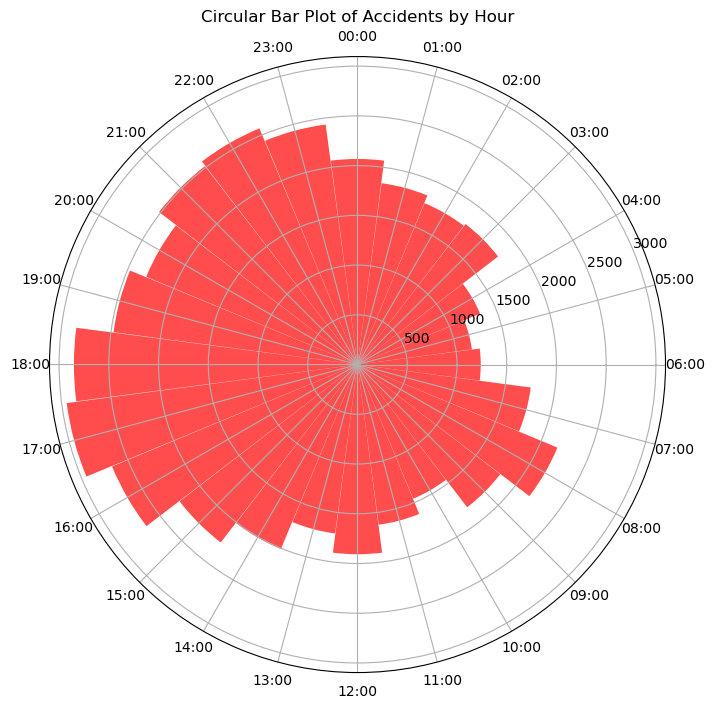

In [ ]:
df_traffic_violations['Hour Of Stop'] = pd.to_datetime(df_traffic_violations['Time Of Stop'], format='%H:%M:%S').dt.hour
# Filter the DataFrame for accidents
df_accidents = df_traffic_violations[df_traffic_violations['Accident'] == 'Yes']

# Group the data by hour and count the number of accidents in each hour
accidents_by_hour_counts = df_accidents['Hour Of Stop'].value_counts().sort_index()

# Plot a circular bar plot to visualize the distribution of accidents by hour
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Convert hours to radians and adjust the starting angle to have 0 at the top
theta_accidents = (-(accidents_by_hour_counts.index * (2 * 3.14159) / 24.0) + (3.14159 / 2)) % (2 * 3.14159)

# Create bars in the polar plot with red color for accidents and some transparency
bars_accidents = ax.bar(theta_accidents, accidents_by_hour_counts.values, width=0.26, color='red', alpha=0.7)

# Set x-axis labels with formatted hour labels
hour_labels_accidents = [f"{hour:02d}:00" for hour in accidents_by_hour_counts.index]
ax.set_xticks(theta_accidents)
ax.set_xticklabels(hour_labels_accidents)

# Set the title for the circular bar plot
plt.title('Circular Bar Plot of Accidents by Hour')

# Display the circular bar plot
plt.show()

1. **Rush Hour Traffic:**
    - This time frame often coincides with rush hour, when many people are commuting home from work. Increased traffic density and congestion during rush hour can lead to a higher likelihood of accidents.
2. **Fatigue and Distraction:**
    - Commuters returning home from work may experience fatigue after a full day's work. Fatigue, combined with distractions like phone use or daydreaming, can contribute to an increase in accidents.
3. **Reduced Visibility:**
    - Depending on the time of the year, the evening hours might experience reduced visibility due to sunset or adverse weather conditions. Diminished visibility can be a contributing factor to accidents.
4. **Sun Glare:**
    - The setting sun during the evening commute can create sun glare, affecting drivers' visibility and making it challenging to see the road and other vehicles.
5. **Stress and Impatience:**
    - After a busy day, drivers may be more stressed and impatient during the evening commute. Aggressive driving behaviors, impatience, and a sense of urgency can increase the risk of accidents.
6. **Varied Skill Levels:**
    - The evening commute may involve a mix of experienced and less-experienced drivers. Inexperienced drivers or those unfamiliar with the evening traffic patterns may contribute to accidents.
7. **School Dismissal:**
    - If there are schools in the area, the afternoon hours often coincide with the time when schools dismiss students. Increased pedestrian and school bus activity can contribute to traffic complexity.
8. **Changing Weather Conditions:**
    - Weather conditions tend to change during the late afternoon and early evening. Factors such as rain, snow, or darkness can impact road conditions and driver behavior, leading to a higher likelihood of accidents.
9. **Intersection Congestion:**
    - Busy intersections, especially in urban areas, may experience congestion and a higher probability of accidents during the evening rush hour.
10. **Delayed Reaction Times:**
    - Commuters may experience mental fatigue and delayed reaction times at the end of the day, making it crucial for drivers to stay alert and focused.

#### Analysing the frequency of accidents occured on each day in every month

Analyzing the frequency of accidents that occurred on each day in every month can provide valuable insights and benefits in several areas:
1. **Identifying Patterns and Trends:**
   - Analyzing accident data over time helps identify patterns and trends. It allows for the detection of recurring patterns on specific days or months, such as increased accident rates during weekends or certain seasons.
2. **Resource Allocation:**
   - Understanding the days and months with a higher frequency of accidents enables more effective resource allocation. Law enforcement agencies can allocate resources, such as traffic patrols or safety campaigns, to times and locations where they are most needed.
3. **Traffic Management:**
   - City planners and traffic management authorities can use the data to optimize traffic flow and address congestion issues during peak accident periods. This may involve adjusting traffic signal timings or implementing traffic control measures.
4. **Targeted Interventions:**
   - The analysis can inform targeted interventions and safety initiatives. For example, if certain months or days consistently show a higher number of accidents, specific safety campaigns or educational programs can be implemented to address the contributing factors.
5. **Infrastructure Improvements:**
   - Data on accident frequency can guide infrastructure improvements. For instance, if a particular intersection has a higher number of accidents during specific months, it may prompt authorities to consider redesigning the intersection or enhancing signage for better safety.
6. **Public Awareness Campaigns:**
   - The information obtained from the analysis can be used to design public awareness campaigns focused on safe driving practices during high-risk periods. These campaigns can target specific months or days to maximize their impact.
7. **Insurance Risk Assessment:**
   - Insurance companies can utilize the data to assess risk and adjust premium rates accordingly. Vehicles registered in regions with higher accident frequencies during certain periods may be associated with different insurance risk profiles.
8. **Emergency Response Preparedness:**
   - Emergency response services can use the data to enhance preparedness during peak accident periods. This may involve adjusting staffing levels or resources to ensure timely and effective responses.
9. **Policy Development:**
   - Policymakers can use the insights gained from the analysis to inform the development or modification of traffic safety policies. This may include the implementation of new regulations or the enhancement of existing ones.
10. **Seasonal Variations:**
    - Understanding the seasonal variations in accident frequency is crucial. Seasonal factors such as weather conditions, holidays, or events can influence driving behavior and road conditions, affecting accident rates.
11. **Enforcement Strategies:**
    - Law enforcement agencies can develop targeted enforcement strategies based on the analysis. For example, increased enforcement and awareness campaigns could be implemented during months or days with historically higher accident rates.
12. **Public Safety Initiatives:**
    - Municipalities and organizations focused on public safety can use the data to design initiatives aimed at reducing accidents and promoting a culture of safe driving.
In summary, analyzing the frequency of accidents by day in every month provides a data-driven approach to improving road safety, optimizing resource allocation, and implementing targeted interventions to reduce accidents and their associated consequences.

In [ ]:
# Step 1: Extract relevant columns and create a copy
accidents_df = df[['Date Of Stop', 'Accident']].copy()

# Step 2: Convert 'Date Of Stop' to datetime object
accidents_df['Date Of Stop'] = pd.to_datetime(accidents_df['Date Of Stop'])

# Step 3: Create a new column for the day of the week
accidents_df['Day Of Week'] = accidents_df['Date Of Stop'].dt.day_name()

# Step 4: Filter the dataframe where 'Accident' is 'yes'
accidents_yes_df = accidents_df[accidents_df['Accident'] == 'Yes']

# Step 5: Group by day of the week and calculate the frequency of accidents where 'Accident' is 'yes'
accident_frequency = accidents_yes_df['Day Of Week'].value_counts().sort_values(ascending=False)
accident_frequency

Sunday       7952
Saturday     7514
Friday       7274
Thursday     6775
Wednesday    6504
Tuesday      6414
Monday       6222
Name: Day Of Week, dtype: int64

## The observation that Sunday has the highest number of accidents may be influenced by various factors. Here are some potential reasons why Sundays could have a higher accident rate:

1. **Increased Traffic:**
    - On Sundays, there may be an increase in traffic due to various factors such as people returning from weekend trips, attending social events, or engaging in recreational activities. Higher traffic volumes can contribute to a greater likelihood of accidents.
2. **Weekend Activities:**
    - People may engage in more social and recreational activities over the weekend, which can involve travel and increased time on the road. This increased activity can lead to a higher probability of accidents.
3. **Fatigue:**
    - Sunday is often associated with the end of the weekend, and individuals may have engaged in various activities or travel during the preceding days. Fatigue can impair reaction times and decision-making, increasing the risk of accidents.
4. **Alcohol Consumption:**
    - Some individuals may consume alcohol during social events or gatherings over the weekend, and this can contribute to an increased risk of accidents, particularly if individuals drive under the influence.
5. **Driver Behavior:**
    - Driver behavior can vary throughout the week. On Sundays, some drivers may adopt a more relaxed or casual attitude, leading to potential lapses in attention and caution, which can contribute to accidents.
6. **Routine Changes:**
    - People often experience changes in their routine over the weekend. These changes, such as altered sleep patterns or schedules, can impact alertness and concentration while driving.

<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

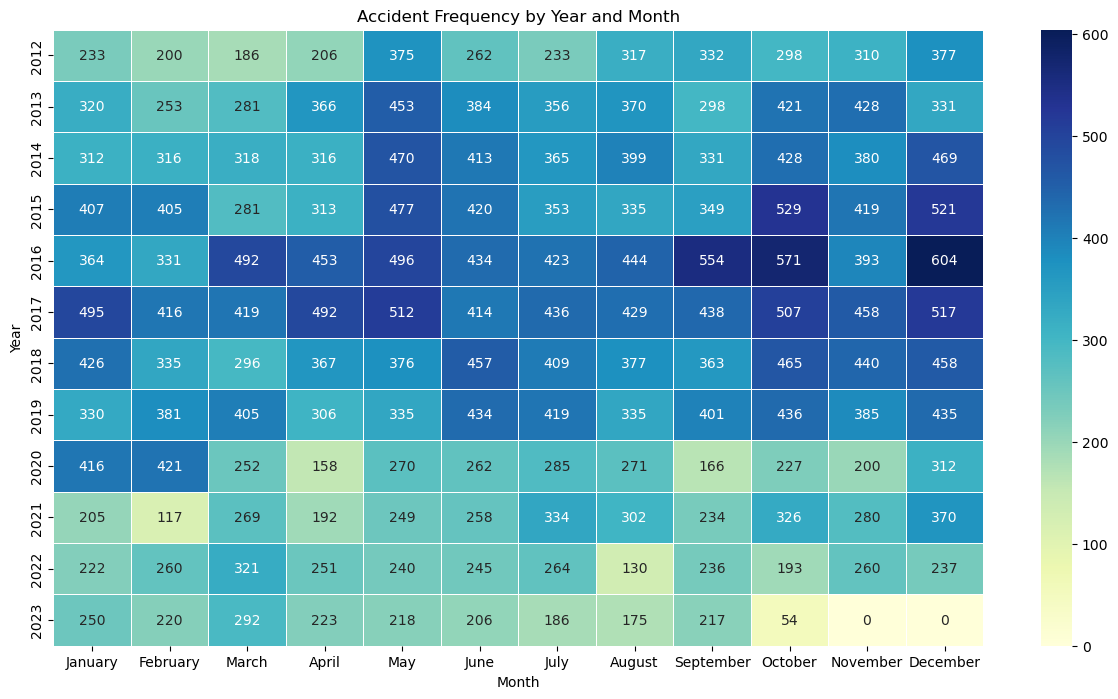

In [ ]:
# Replace 'Date Of Stop' and 'Accident' with the actual column names in your dataset

# Step 1: Extract relevant columns and create a copy
accidents_df = df[['Date Of Stop', 'Accident']].copy()

# Step 2: Convert 'Date Of Stop' to datetime object
accidents_df['Date Of Stop'] = pd.to_datetime(accidents_df['Date Of Stop'])

# Step 3: Create new columns for the year and month
accidents_df['Year'] = accidents_df['Date Of Stop'].dt.year
accidents_df['Month'] = accidents_df['Date Of Stop'].dt.month_name()

# Step 4: Filter the dataframe where 'Accident' is 'Yes'
accidents_yes_df = accidents_df[accidents_df['Accident'] == 'Yes']

# Step 5: Group by year and month and calculate the frequency of accidents
accident_frequency = accidents_yes_df.groupby(['Year', 'Month']).size().unstack(fill_value=0)

# Order months
months_order = list(month_name[1:])  # exclude the first element which is an empty string

# Step 6: Create a heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(accident_frequency[months_order], cmap="YlGnBu", annot=True, fmt="d", linewidths=.5)

plt.title('Accident Frequency by Year and Month')
plt.xlabel


The heatmap analysis reveals a notable increase in accidents during **December** and **October**, indicating a trend that warrants further investigation.Some possible reasons for an increase in accidents during this time include:
1. **Weather Conditions:**
    - In many regions, December is associated with winter, bringing cold temperatures, snow, and icy conditions. Inclement weather can lead to slippery roads and reduced visibility, increasing the likelihood of accidents.
2. **Holiday Season:**
    - December includes various holidays such as Christmas and New Year's Eve. Increased travel, shopping, and social activities during this period may result in more vehicles on the road, leading to a higher probability of accidents.
3. **Daylight Hours:**
    - December has shorter daylight hours, and the increased darkness can contribute to reduced visibility and challenging driving conditions.
4. **Drunk Driving:**
    - The holiday season is unfortunately associated with an increase in alcohol consumption. This, combined with holiday celebrations, can lead to an elevated risk of drunk driving incidents.
5. **Year-End Rush:**
    - The end of the calendar year often involves increased activities, both personal and professional. People may be in a rush to complete tasks before the year ends, leading to more traffic and potentially more accidents.


There is also a notable number of accidents getting reported during the months of  **May** and **June** which could be attributed to the confluence of seasonal activities.With the onset of summer,more people could be encouraged to hit the outdoors and travel more,especially during the Memorial Day Weekend.Also,during the summer,as the academic years are coming to an end, more young,inexperienced drivers could be prevalent on the roads increasing the chances of accidents.

## 3.

After looking at the dataset, it seems that the `SubAgency` column could be a good choice for grouping violation zones.Now, let's proceed to examine the unique values within this column to determine if it's the right choice for grouping violation zones. This step will help us understand the diversity and distribution of the data for more accurate grouping.

In [ ]:
# Returns the unique values of "SubAgency" Column
df['SubAgency'].unique()

array(['6th District, Gaithersburg / Montgomery Village',
       '4th District, Wheaton', 'Headquarters and Special Operations',
       '3rd District, Silver Spring', '2nd District, Bethesda',
       '1st District, Rockville', '5th District, Germantown', 'W15',
       'S15'], dtype=object)

The `SubAgency` column contains unique values representing districts within Montgomery County, making them suitable for categorizing violations into different zones. However, we have identified three values - **W15**, **S15**, and **Headquarters and Special Operations** - that don't appear to correspond to districts. To decide how to handle these, let's investigate the number of entries associated with each of these values. This approach will guide our decision-making process regarding their inclusion or modification in our analysis.

In [ ]:
# Returns the count of the value "W15" in the "SubAgency" column.
df['SubAgency'].value_counts()['W15']

2

In [ ]:
# Returns the count of the value "S15" in the "SubAgency" column.
df['SubAgency'].value_counts()['S15']

1

Upon examining the frequency of **W15** and **S15** in the dataset, we found that they are present in only 3 records, a negligible amount considering the overall size of the dataset. Additionally, these values do not seem to have a clear connection to zoning information in Montgomery County. Therefore, it would be prudent to exclude these records for a more accurate and focused analysis. This step will enhance the reliability of our findings by concentrating on relevant and clearly defined data.

To conduct a meaningful analysis on violation zones, we will remove records that have 'SubAgency' values of 'W15' and 'S15'. This step ensures that our analysis is focused on relevant and clearly defined data.

In [ ]:
# Filter out records with 'SubAgency' values 'W15' or 'S15' from the dataframe for more focused analysis.
df2 = df[df['SubAgency'].str.contains('W15|S15')==False]

In [ ]:
# Returns the count of the value 'Headquarters and Special Operations' in the "SubAgency" column.
df2['SubAgency'].value_counts()['Headquarters and Special Operations']

83150

Upon reviewing the dataset, we discovered that the 'Headquarters and Special Operations' value within the 'SubAgency' column is associated with a considerable number of records. This value denotes a distinct area in Montgomery County that includes the Traffic Headquarters and Special Operations. This classification is probably maintained to efficiently track traffic violations occurring near these key locations. This insight suggests the value's relevance and utility in our analysis.

To enhance our zonal analysis, we'll substitute **Headquarters and Special Operations** in the `SubAgency` column with **1st District, Rockville**. This change reflects the fact that Montgomery County's Department of Transportation headquarters are located in the Rockville district, providing a more precise geographical reference for our analysis. [1]

In [ ]:
#Replacing 'Headquarters and Special Operations' with '7th District, Burtonsville' in the 'SubAgency' column.
zonal_data = df2.copy()
zonal_data['SubAgency'] = zonal_data['SubAgency'].replace('Headquarters and Special Operations', '1st District, Rockville')

Having refined the data for our zonal violation analysis, let's now examine the distribution of violations across different districts within Montgomery County. This will offer valuable insights into the patterns and trends of traffic violations in various areas.

In [ ]:
#Counting the number of violations by 'SubAgency' (Zones) sorted in descending order of the number of violation
df_zone_violations_count = zonal_data['SubAgency'].value_counts().sort_values(ascending=False)

# Returns the zone violations count
df_zone_violations_count

4th District, Wheaton                              224423
1st District, Rockville                            200881
3rd District, Silver Spring                        191604
2nd District, Bethesda                             167421
5th District, Germantown                           136983
6th District, Gaithersburg / Montgomery Village    127260
Name: SubAgency, dtype: int64

The analysis reveals that **Wheaton** has the highest number of violations, while **Germantown** records the fewest in Montgomery County. Given that Rockville hosts the traffic headquarters and special operations office, we can see that the presence of these facilities doesn't influence public adherence to traffic rules, as it has the 3rd highest violations when compared to all the districts within Montgomery county. People generally have the perception that areas with traffic headquarters or offices experience more thorough traffic monitoring, contributing to the lower violation count but its not the case for Montgomery County.

Having examined the overall trend of traffic violations across Montgomery County's districts, we can now delve deeper to understand the nature of these violations. Specifically, we'll explore how they were categorized - as Warnings, Citations, ESERO (Electric Safety Equipment Repair Order), or SERO (Safety Equipment Repair Order) - within each district. This detailed analysis will provide a clearer picture of the types of enforcement actions prevalent in different areas.

In [ ]:
#Counting the occurrences of each type withing each 'SubAgency'(District)
df_zone_violation_types_by_district = df2.groupby('SubAgency')['Violation Type'].value_counts()

# Displays the occurrences
df_zone_violation_types_by_district

SubAgency                                        Violation Type
1st District, Rockville                          Citation           87307
                                                 Warning            30246
                                                 ESERO                177
                                                 SERO                   1
2nd District, Bethesda                           Citation          138292
                                                 Warning            28911
                                                 ESERO                212
                                                 SERO                   6
3rd District, Silver Spring                      Citation          172486
                                                 Warning            18957
                                                 ESERO                160
                                                 SERO                   1
4th District, Wheaton                           

The analysis indicates that the frequency of Warnings and Citations issued falls within a similar range, while the issuance of ESEROs and SEROs (repair orders for vehicles not meeting the required standards) is considerably lower in comparison. Without data on the number of registered vehicles per district, it's challenging to determine the public's adherence to vehicle standards set by the traffic division. Additional information would be required for more comprehensive insights. However, it's noticeable that the issuance of physical SEROs has declined with the shift towards Electric SEROs, suggesting a preference for electronic methods by traffic agencies due to their convenience.

Let's proceed to analyze the most frequently issued types of violations in each district. This will provide further insights into the specific nature of traffic violations prevalent in different areas of Montgomery County.

Next, it would be insightful to explore the key factors contributing to violations. We'll focus on common reasons such as accidents, failure to wear seat belts, damaging property, and driving under the influence. Analyzing these factors will help us understand the primary causes behind the traffic violations in the dataset.

In [ ]:
# Define a list of specific violation types for analysis
violation_type = ['Accident', 'Belts', 'Property Damage', 'Alcohol']

# Calculate the total number of each violation type by checking if the value is 'Yes'
violation_total = df[violation_type].apply(lambda x: (x == 'Yes').sum(), axis=0)

# Display the calculated totals
violation_total

Accident           48655
Belts              42597
Property Damage    37753
Alcohol             2466
dtype: int64

The analysis reveals that failing to wear seat belts is the most frequent violation, surpassing both accidents and property damage. Driving under the influence has a notably lower incidence compared to the other three reasons. This suggests that in Montgomery County's districts, either fewer people drive under the influence, or they are more likely to opt for cab rides when inebriated, instead of driving themselves. This trend reflects a possible heightened awareness or caution among residents regarding the risks of drunk driving.

Having identified the common types of traffic violations, we can now explore their distribution across different districts in Montgomery County. This analysis will shed light on driver behaviors in various areas and assist traffic authorities in tailoring their monitoring strategies to address specific local needs.

In [ ]:
#Making a new dataframe to do geospatial analysis
df_filtered = df2[violation_type + ['SubAgency','Longitude','Latitude']]

#Counting occurrences of each violation type by grouping on 'SubAgency'
districtwise_violation_counts = df_filtered.groupby('SubAgency').apply(lambda x: (x == 'Yes').sum())

# Remove the 'SubAgency' column from the district-wise violation counts dataframe for a more focused analysis on violation types.
districtwise_violation_counts=districtwise_violation_counts.drop(['SubAgency'],axis=1)

# Diplays the violations counts in each district
districtwise_violation_counts[violation_type]

,Accident,Belts,Property Damage,Alcohol
SubAgency,,,,
"1st District, Rockville",4614,9092,3197,153
"2nd District, Bethesda",8541,3861,5729,237
"3rd District, Silver Spring",9440,9610,8624,144
"4th District, Wheaton",14650,5944,10419,271
"5th District, Germantown",4843,466,4522,1314
"6th District, Gaithersburg / Montgomery Village",4963,10669,3888,292
Headquarters and Special Operations,1604,2955,1374,55


The data indicates that accidents and **not wearing seat belts** are the most common violations across all districts. To gain a clearer understanding of which violation predominates in each district, we will compile a list highlighting the top occurring violation for every district. This approach will provide a nuanced view of prevalent traffic issues in specific areas, aiding in targeted enforcement and education efforts.

In [ ]:
# Identify the most frequent violation type in each district by finding the maximum count across columns for each row in the districtwise_violation_counts dataframe.
districtwise_violation_counts.idxmax(axis=1)

SubAgency
1st District, Rockville                               Belts
2nd District, Bethesda                             Accident
3rd District, Silver Spring                           Belts
4th District, Wheaton                              Accident
5th District, Germantown                           Accident
6th District, Gaithersburg / Montgomery Village       Belts
Headquarters and Special Operations                   Belts
dtype: object

Let's plot the above violation types on a geospatial map to idetify where they occurred exactly and if its possible to identify any violation hotspots within various districts so that the district traffic authorities can assign personnel and teams accordingly with the aim of reducing these violations.

In [ ]:
# Filter the dataframe to include only those records where at least one of the specified violations ('Accident', 'Belts', 'Property Damage', or 'Alcohol') occurred.
df_filtered_dummy = df_filtered[(df_filtered['Accident'] == 'Yes') | (df_filtered['Belts'] == 'Yes') |
                 (df_filtered['Property Damage'] == 'Yes') | (df_filtered['Alcohol'] == 'Yes')]

# Transform the violation type variables into dummy variables (1 for 'Yes' and 0 for 'No') to facilitate plotting and analysis.
df_filtered_dummy = df_filtered_dummy.replace({'Yes': 1, 'No': 0})


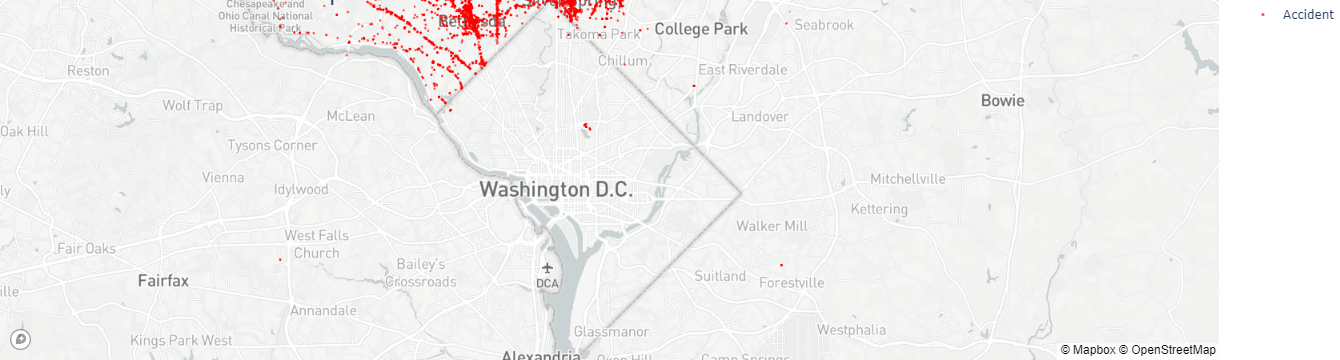

In [ ]:
# Define a dictionary for assigning unique colors to different violation types
incident_colors = {
    'Accident': 'red'
}

# Initialize an empty figure for the map visualization
fig = go.Figure()

# Loop through each violation type and add markers to the map for each type
for incident_type, color in incident_colors.items():
    # Filter the dataframe for each specific violation type
    filtered_type_df = df_filtered_dummy[df_filtered_dummy[incident_type] == 1]

    # Add scattermapbox traces to the figure for each violation type
    fig.add_trace(go.Scattermapbox(
        lat=filtered_type_df['Latitude'],
        lon=filtered_type_df['Longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=3,
            color=color,
            opacity=0.7
        ),
        name=incident_type,
        text=filtered_type_df[incident_type],
        hoverinfo='text'
    ))

# Customize the map's appearance and settings
fig.update_layout(
    mapbox=dict(
        accesstoken='pk.eyJ1IjoiYW51anNoYXJtYTEwIiwiYSI6ImNsb3o0NmVqaTA5Z3Iya3BwdWI2eHBnY2EifQ._iH1n3LU5uevogVeKDKspg',  # Replace with your Mapbox access token
        center=go.layout.mapbox.Center(lat=38.9, lon=-77.0),  # Set the initial position of the map
        zoom=10
    ),
    showlegend=True,
    legend=dict(
        bgcolor='rgba(255,255,255,0.7)',
        orientation='v'
    ),
    title=dict(
        text='Incident Overview Map',  # Map title
        font=dict(size=24)
    ),
    margin=dict(t=0, l=0, r=0, b=0)
)

# Display the interactive map
fig.show()

From the above analysis, we can see that there are a few areas which have a lot of accidents accidents
1. Glenmont - near police department and clustered around intersections
2. White Oak - near police department and clustered around intersections
3. Wheaton - bigger intersections like University Blvd W, Georgia Ave have a lot of acccidents
4. Bethesda
a. (intersection of Wisconsin and Montgomery Ave) - Has a lot of hotels nearby
b. (intersection of Rugby and Woodmont Ave) - primarily inside and around Woodmont Rugby Garage
c. Near Suburban Hospital
5. Silver Spring - clustered around main road junctions
6. German Town - near police department and clustered around intersections
In general the suburban areas(city centers) have higher accidents and country side areas like Lantonsville, Brookeville, Poolesville, Bealsville, Barnesville have way lesser accidents

The clusters of accidents near police departments in Glenmont, White Oak, and Germantown could indicate high-traffic volumes in these areas despite the presence of law enforcement facilities. It could also suggest that other factors such as road design or traffic flow may contribute to the occurrence of accidents.

The Bethesda area, particularly the intersections of Wisconsin and Montgomery Ave, and the surroundings of the Woodmont Rugby Garage, exhibit higher accident rates. This may be due to the complex urban infrastructure, with a dense concentration of hotels and parking facilities contributing to increased vehicle and pedestrian interaction.

Law enforcement agencies could use this data to identify areas where increased traffic enforcement may be needed. Additionally, public awareness campaigns focusing on road safety could be more effectively targeted in areas with higher accident rates.

### 4. Are individuals of a specific race subjected to more stop searches and arrests for violations compared to others? How has this pattern evolved over time?

In today's society, traffic enforcement serves as a pivotal link between law enforcement procedures and societal fairness. Nonetheless, there are ongoing concerns about possible racial biases and inequalities in how searches are carried out during regular traffic stops. Analyzing the frequency and trends of searches among diverse racial demographics has emerged as a key focus for researchers, policymakers, and advocates aiming to uphold fairness and impartiality in law enforcement procedures.Such disparities, if present, could signify systemic issues within law enforcement, potentially leading to distrust and exacerbating societal divides.

Analyzing racial disparities in search conduct during traffic violations holds multifaceted importance. Firstly, it serves as a lens through which potential biases within law enforcement practices can be assessed. Secondly, it highlights the need for transparency and accountability in policing, essential elements for fostering community trust. Moreover, it contributes to ongoing conversations on racial equity and social justice, sparking policy discussions aimed at mitigating disparities.

The objective of this analysis is to investigate and clarify potential differences in the frequency or methods of searches carried out during traffic infractions among various racial groups. We also want to offer insights into the occurrence and characteristics behind these variations. This aims to facilitate well-informed discussions and evidence-driven policy actions.

In [ ]:
# Filter the violations involving Search
search_conducted_data = df[(df['Search Conducted'] == 'Yes')].copy()

print("Total number of searches in the dataset : ",len(search_conducted_data))

Total number of searches in the dataset :  68451


We will be examining the proportion of searches conducted on individuals from different racial backgrounds relative to the total number of searches that were conducted. Investigating these search rates provides insights into whether certain racial groups are disproportionately subjected to searches during traffic stops, offering a lens into potential biases or systemic inequalities

In [ ]:
# Find the total violations per year
total_violations_per_year = df.groupby('Year').size()
#Group by 'Year' and 'Race', count searches, and calculate the proportion
violations_by_race = df.groupby(['Year', 'Race']).size().reset_index(name='Race_Count')
violations_by_race['Violation_Proportion'] = violations_by_race.apply(
    lambda row: row['Race_Count'] *100/ total_violations_per_year[row['Year']], axis=1
)

# Pivot the data for plotting
violation_data = violations_by_race.pivot(index='Race', columns='Year', values='Violation_Proportion')

search_formatted = violation_data.applymap(lambda x: '{:.2f}%'.format(x))
search_formatted

Year,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Race,,,,,,,,,,,,
ASIAN,5.28%,5.36%,5.47%,5.29%,5.29%,4.94%,5.13%,4.79%,4.22%,3.92%,3.81%,4.42%
BLACK,29.93%,30.83%,28.90%,30.25%,32.16%,32.43%,32.41%,31.83%,33.83%,29.48%,31.37%,31.28%
HISPANIC,18.44%,20.22%,21.20%,23.44%,24.60%,24.69%,25.03%,25.97%,29.47%,31.23%,33.34%,27.26%
NATIVE AMERICAN,0.02%,0.16%,0.37%,0.28%,0.23%,0.19%,0.11%,0.05%,0.03%,0.02%,0.05%,0.10%
OTHER,4.84%,4.46%,4.88%,4.81%,4.94%,5.18%,5.09%,5.96%,5.15%,9.50%,9.61%,11.29%
WHITE,41.48%,38.97%,39.19%,35.92%,32.78%,32.57%,32.22%,31.39%,27.29%,25.85%,21.82%,25.65%


The data reflects notable racial disparities in traffic and violation rates. While **Black** and **Hispanic** individuals consistently constitute a higher share of traffic violations, the trend is particularly pronounced for Hispanic individuals, showing a significant increase over time.  
Conversely, the share of violations involving White individuals is notably lower and decreasing. These trends might suggest potential differences in enforcement practices based on race, possibly indicating racial profiling or targeted enforcement.

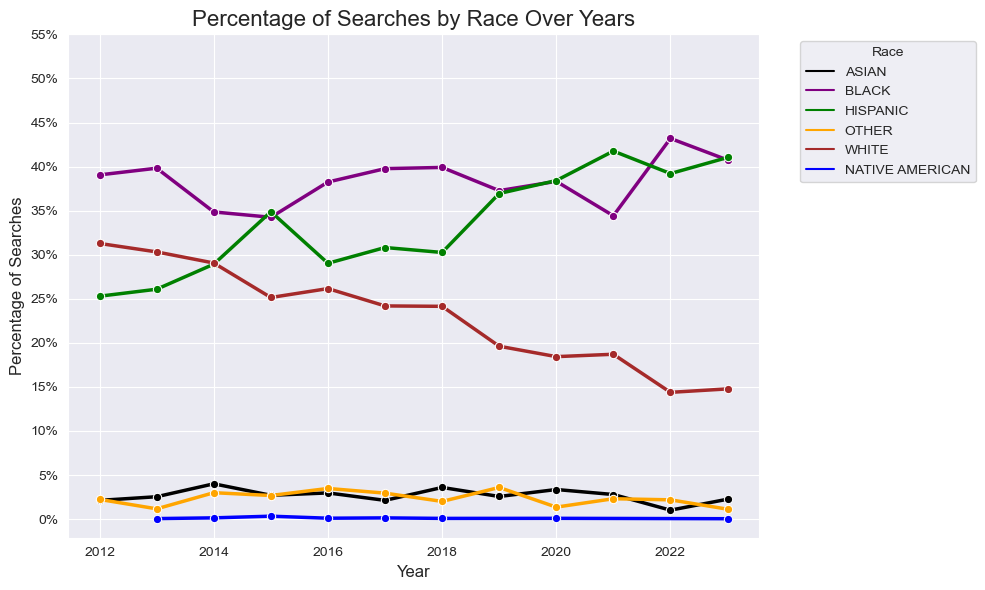

In [ ]:
# Step 1: Calculate the total count of searches for each year
total_searches_per_year = search_conducted_data.groupby('Year').size()

# Step 2: Group by 'Year' and 'Race', count searches, and calculate the proportion
searches_by_race = search_conducted_data.groupby(['Year', 'Race']).size().reset_index(name='Race_Count')
searches_by_race['Search_Proportion'] = searches_by_race.apply(
    lambda row: row['Race_Count'] *100/ total_searches_per_year[row['Year']], axis=1
)

# Define custom colors for each race
colors = {'BLACK':'purple','ASIAN':'black','HISPANIC': 'green','WHITE': 'brown', 'OTHER':'orange','NATIVE AMERICAN':'blue'}  # Customize as needed

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=searches_by_race,
    x='Year',
    y='Search_Proportion',
    hue='Race',
    marker='o',
    palette=colors,  # Using the defined color palette
    linewidth=2.5
)

plt.title('Percentage of Searches by Race Over Years', fontsize=16)
plt.xlabel('Year', fontsize=12)

# Adjusting y-axis labels to show every 5% with a '%' symbol
plt.yticks([i for i in range(0, 56, 5)], [f'{i}%' for i in range(0, 56, 5)])

plt.ylabel('Percentage of Searches', fontsize=12)
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<b>1. Dominant Groups in Searches:</b> The data indicates that Black, Hispanic, and White individuals constitute the majority of the subjects of police searches, with these three racial groups combined accounting for over 80% of all searches.

<b>2. Stability Among Other Races:</b> Searches involving races other than Black, Hispanic, and White remain relatively low and consistent, not exceeding 10% of the total. Their uniform representation over time suggests that there has been little change in police interaction with these groups, at least in terms of search incidence.

<b>3. Trends in Minority Searches:</b> Starting from 2016, there has been a notable trend where the percentage of searches involving Black and Hispanic individuals has been on the rise, whereas the searches involving White individuals have shown a decline. This could indicate a shift in focus or policy that has affected the search patterns within the county.

Given that the bulk of searches were carried out on three specific racial groups — Black, Hispanic, and White individuals — our subsequent analysis will primarily concentrate on these categories. To gain a deeper insight into the nuances of these searches, we will examine four key aspects for the aforementioned races:

1. **The Probability of Being Searched Upon Being Stopped:** Assessing the frequency at which individuals from these racial groups are searched during a traffic stop.

2. **Primary Justifications for Conducting Searches:** Identifying the most frequently cited reasons and legal provisions underpinning these searches.

3. **Search Disposition:** Analyzing what typically transpires as a result of these searches.

4. **The Outcomes of the Searches:** Determining the ultimate results or actions taken following the searches.

#### Likelihood of Search

As previously noted, approximately 6.5% of traffic stops for violations result in searches. The probability of a driver of a specific race being subjected to a search can provide an initial framework to comprehend the varying interactions people of color have with law enforcement, in contrast to those of white individuals.

In [ ]:
# Filter the data to include the data for the 3 races
filtered_data = search_conducted_data[search_conducted_data['Race'].isin(['HISPANIC', 'BLACK', 'WHITE'])]

# Calculate counts of stops and searches for each race over the years
race_counts = df.groupby(['Race', 'Year']).size().reset_index(name='Stops')
search_counts = filtered_data.groupby(['Race', 'Year']).size().reset_index(name='Searches')

# Calculate search  percentages
search_percentage = race_counts.merge(search_counts, on=['Race', 'Year'], how='left')

search_percentage['Search_Percentage'] = (search_percentage['Searches'] / search_percentage['Stops']) * 100

# Pivot tables to visualize better
search_pivot = search_percentage.pivot_table(index='Race', columns='Year', values='Search_Percentage')

# Formatting the pivot tables
search_formatted = search_pivot.applymap(lambda x: '{:.2f}%'.format(x))

# Convert the pivot tables to formatted table
search_table = tabulate(search_formatted, headers='keys', tablefmt='pretty')

# Display the formatted tables
print("Search Percentage by Race and Year:")
print(search_table)


Search Percentage by Race and Year:
+----------+-------+-------+-------+-------+-------+-------+-------+--------+--------+-------+-------+-------+
|   Race   | 2012  | 2013  | 2014  | 2015  | 2016  | 2017  | 2018  |  2019  |  2020  | 2021  | 2022  | 2023  |
+----------+-------+-------+-------+-------+-------+-------+-------+--------+--------+-------+-------+-------+
|  BLACK   | 5.57% | 8.50% | 6.30% | 7.41% | 8.55% | 9.52% | 8.92% | 8.34%  | 10.32% | 8.21% | 9.95% | 6.69% |
| HISPANIC | 5.86% | 8.49% | 7.13% | 9.74% | 8.49% | 9.69% | 8.76% | 10.14% | 11.88% | 9.40% | 8.50% | 7.73% |
|  WHITE   | 3.22% | 5.12% | 3.87% | 4.58% | 5.74% | 5.77% | 5.43% | 4.45%  | 6.15%  | 5.09% | 4.76% | 2.96% |
+----------+-------+-------+-------+-------+-------+-------+-------+--------+--------+-------+-------+-------+


### Observations
1. Upward Trend in Searches for Black and Hispanic Individuals:
There's a noticeable upward trajectory in the search percentages for both Black and Hispanic races over these years.
The highest search rate for Black individuals occurred in 2020 (10.32%), and for Hispanic individuals, it was also in 2020 (11.88%).  

2. Lower and More Stable Search Percentages for White Individuals:
The search percentage for White individuals remains consistently lower than that for Black and Hispanic individuals throughout the years.
The peak for White individuals was also in 2020 (6.15%), but it's notably lower than the peaks for the other two groups.   

3. Peaks in 2020 for All Groups:
All racial groups experienced their highest search percentages in 2020, possibly due to global COVID-19 pandemic and its impact on law enforcement practices.  

4. Post-2020 Decrease:  After 2020, there is a noticeable decrease in search percentages for all groups, with 2023 showing a significant drop, especially for White individuals (2.96%).

Considering the calculated figures, it can be stated that Blacks and Hispanics are approximately 1.5 times more likely to be subjected to searches compared to White individuals.But a conclusion cannot be made solely based on these numbers as these differences may echo circumstances that do not reflect an individual officer’s bias.

#### SubAgency level likelihood

In [ ]:
# Group data by subagency and race violation, then count the number of searches
searches_by_race_subagency = filtered_data.groupby(['SubAgency', 'Race']).size().reset_index(name='Searches')

# Group data by subagency to get total searches in each subagency
total_searches_subagency = df.groupby(['SubAgency', 'Race']).size().reset_index(name='TotalSearches')

# Merge the two dataframes to calculate proportions
combined_df = pd.merge(searches_by_race_subagency, total_searches_subagency, on=['SubAgency', 'Race'])

# Calculate the percentage of searches for each race in each sub-agency
combined_df['Proportion'] = combined_df['Searches'] *100/ combined_df['TotalSearches']
pivoted_table = combined_df.pivot_table(index='Race', columns='SubAgency', values='Proportion', fill_value=0)

# Display the pivoted table
styled_table = pivoted_table.style\
    .set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}])\
    .background_gradient(cmap='PuBuGn')\
    .format('{:.2f}%')

styled_table

SubAgency,"1st District, Rockville","2nd District, Bethesda","3rd District, Silver Spring","4th District, Wheaton","5th District, Germantown","6th District, Gaithersburg / Montgomery Village",Headquarters and Special Operations
Race,,,,,,,
BLACK,7.62%,5.64%,10.62%,8.61%,5.59%,6.73%,7.17%
HISPANIC,6.62%,5.59%,11.91%,9.09%,4.66%,7.36%,11.35%
WHITE,5.47%,2.96%,6.37%,6.25%,3.79%,4.11%,5.50%


1. Elevated Search rates for Black and Hispanic Groups in Specific Regions:
In Silver Spring's 3rd District, there is a noticeable increase in the stop rates for Black (10.62%) and Hispanic (11.91%) individuals when compared to other areas. Similarly, the 6th District (Gaithersburg/Montgomery Village) and the Headquarters and Special Operations divisions also exhibit higher stop rates for Hispanic individuals, at 7.36% and 11.35% respectively.

2. Reduced Stop rates for White Individuals:
In most districts, White individuals experience lower stop percentages than their Black and Hispanic counterparts. Notably, the 2nd District (Bethesda), which is more developed and predominantly White, records the lowest stop percentage for White individuals at 2.96%. This demographic and developmental composition of Bethesda may play a role in this trend.

3. Distinct Patterns in Sub-Agencies:
Each sub-agency demonstrates unique stop trends. For instance, the 5th District (Germantown) shows generally lower stop percentages across all racial groups. In contrast, the 3rd District (Silver Spring) and the Headquarters and Special Operations divisions are characterized by higher stop percentages, particularly for Hispanic individuals.

#### Search Reason

Now, let us find the proportion of **Search Reasons** documented for the searches that were conducted for the 3 races.

In [ ]:
# Find the proportion search reaon
search_reason_df = filtered_data.groupby('Race')['Search Reason'].value_counts(normalize=True).unstack().fillna(0)

# Convert proportions to percentages and format
search_reason_df = search_reason_df.applymap(lambda x: "{0:.2f}%".format(x*100))

# Display the DataFrame
search_reason_df

Search Reason,Arrest/Tow,Consensual,Exigent Circumstances,Incident to Arrest,K-9,Other,Probable Cause,Probable Cause for CDS,plain view marijuana
Race,,,,,,,,,
BLACK,0.00%,14.05%,0.62%,54.61%,2.22%,1.27%,27.23%,0.00%,0.00%
HISPANIC,0.01%,8.09%,0.62%,77.11%,0.44%,1.13%,12.59%,0.00%,0.00%
WHITE,0.00%,10.99%,0.87%,70.67%,1.48%,1.87%,14.08%,0.02%,0.00%


<b>Observations</b><br>
<b>Incident to Arrest:</b>  
The most common search reason for all races is `'Incident to Arrest'`, with 54.61% for Black, 77.11% for Hispanic, and 70.67% for White individuals.
This indicates that a large proportion of searches are conducted following an arrest.

<b>Probable Cause:</b>  
`'Probable Cause'` is the second most common reason for Black individuals (27.23%), but less so for Hispanic (12.59%) and White (14.08%) individuals.

<b>Consensual Searches:</b>  
`Consensual searches` are relatively more common for **Black** individuals (14.05%) compared to Hispanic (8.09%) and White (10.99%) individuals.

<b>Low Use of K-9 and Other Methods:</b>
Searches involving K-9 units and other unspecified methods are relatively low across all races.


Although `Incident to Arrest` emerges as the predominant search reason, the percentage of searches conducted under this category varies among different races. Notably, individuals of the <b>Black</b> race are searched less frequently in this manner compared to others. The relatively high incidence of `consensual` and `Probable Cause` searches among Black individuals might indicate potential bias in the manner in which consent is solicited or granted. To gain a comprehensive understanding of these discrepancies, it's crucial to factor in additional contexts, such as the results of the searches and recovery of contraband.

#### Search Disposition

Given the higher proportion of searches based on probable cause among minority races, further investigation into the disposition of these searches is necessary. This will help us understand the hit rate of the searches

In [ ]:
#Filter the cases where Probable cause was stated
probable_cause_data = filtered_data[filtered_data['Search Reason']== 'Probable Cause' ]

#Group by the race and disposition
probable_cause_grouped = probable_cause_data.groupby(['Race', 'Search Disposition']).size().reset_index(name='Count')

# Calculate total count for each race
total_counts = probable_cause_grouped.groupby('Race')['Count'].transform('sum')

# Calculate the percentage for each search disposition under each race
probable_cause_grouped['Percentage'] = (probable_cause_grouped['Count'] / total_counts) * 100

# Pivot the table to display search disposition percentages for each race
disposition_table = probable_cause_grouped.pivot(index='Race', columns='Search Disposition', values='Percentage').fillna(0)

disposition_table

Search Disposition,Contraband Only,Contraband and Property,Nothing,Property Only,marijuana
Race,,,,,
BLACK,49.457058,20.180511,25.708645,4.653786,0.00000
HISPANIC,49.508197,17.158470,28.051002,5.173042,0.10929
WHITE,57.892527,19.563392,18.555835,3.988245,0.00000


It is clear that the highest percentage of searches resulting in finding contraband and/or property is among White individuals (~77%), followed  by Black (70%) and Hispanic (66%) individuals.One possible explanation for this could be that implicit biases among law enforcement officers could lead to differential treatment based on race. Officers may unconsciously associate minority groups with criminality more readily, leading to more frequent but less targeted searches.
Conversely, there might be an unconscious bias that associates White individuals with non-criminal behavior, leading to searches only when there's substantial evidence or suspicion.

#### Search Outcome

In [ ]:
Next, we will focus on examining the results of search practices across diverse racial groups.

SyntaxError: invalid syntax (1733571713.py, line 1)

In [ ]:
#Find the poportion of Search outcomes
proportion_df = filtered_data.groupby('Race')['Search Outcome'].value_counts(normalize=True).unstack().fillna(0)

# Convert proportions to percentages and format
proportion_df = proportion_df.applymap(lambda x: "{0:.2f}%".format(x*100))
proportion_df

We can see that the search outcome of the 3 races is varied.While a higher proportion of searches for **Hispanics** resulted in arrests (close to 82%) , blacks had the least number of arrests following a search.This could be as a result of the type of violation that the individual has committed and not merely due to the the outcome of search.

To summarise,
1. The share of searches conducted on Blacks and Hispanic Races accounted for close to 80% of all the searches which has been showing an upward trend since 2016
2. The likelihood a minority getting searched is also greater than that of Whites - almost 1.5 times greater
3. The most common reason stated for searches conducted was Incident to Arrest.But despite this only about 54% of the searches among blacks were under this category compared to 70% of Whites.
4. Searches that were conducted for Blacks and Hispanics under the reason 'Probable Cause', yielded lesser shares of recovering contrabands compared to the searches conducted for Whites.
5. The number of arrests after a search was more prfound in the case of Whites

The data points suggest a pattern where minorities, particularly Blacks and Hispanics, are more frequently subjected to searches, often with less substantial outcomes (in terms of contraband recovery) compared to Whites.
These patterns may reflect racial biases in policing practices or systemic issues within law enforcement strategies.